In [83]:
# Set up 
from pprint import pprint
import pandas as pd
from pathlib import Path


# Get the current directory
current_directory = Path.cwd()

# Get folder names
dir_dat = current_directory.parent.parent.parent / "0_data" / "clean_data"
dir_res = current_directory.parent.parent.parent / "2_results"

# Read in data from meet in middle analysis
#df = pd.read_csv(dir_res / 'meet_in_middle_res_sig_020924.csv')

# Read in proteomics metadata
prot_metadata = pd.read_csv(dir_dat / 'Proteome metadata.csv')

# Remove all "_#"
prot_metadata.EntrezGeneSymbol.str.replace("(::).*","", regex=True)

# Drop NAs
prot_metadata = prot_metadata[prot_metadata['EntrezGeneSymbol'].notnull()]

# Get names of genes
Entrez_Gene_Symbols = prot_metadata.EntrezGeneSymbol

# Split symbols on '|', and flatten the list
split_genes = [symbol for item in Entrez_Gene_Symbols for symbol in item.split('|')]

# Combine Genes into str
Entrez_Genes = "[" + ", ".join(["'" + symbol + "'" for symbol in split_genes]) + "]"

#print(split_genes)
#print(split_genes)
#type(Entrez_Genes)
#print(type(prot_metadata.EntrezGeneSymbol))

In [85]:
# If we only want to include those from the meet_in_the_middle with a sig. total effect: 
#genes_min = ['PSENEN', 'SGK1', 'APOA1','GPNMB', 'GDF11', 'MSTN', 'TGIF2LX', 'SPANXA1', 'ATG3', 'TMEM87B', 'FGF8','RNF114','COLGALT1'] 

#genes_min = ['ZFP91', 'ADGRG5', 'ANP32C'] 

Entrez_Genes = "[" + ", ".join(["'" + symbol + "'" for symbol in genes_min]) + "]"

In [9]:
! python --version

Python 3.10.9


# 1. Query ComptoxAI database using Neo4j.
## 1.a. Identify all nodes linking PFNA, genes, and the outcome. 
Note: to get this to run, you have to have an Neo4j instance of comptoxai.

In [86]:
# Connect to neo4j database
import comptox_ai
from comptox_ai.db.graph_db import GraphDB
db = GraphDB(username="cytoscape", password= "12345", hostname="localhost:7687")
#db = GraphDB(username="neo4j_user", password="12345", hostname="localhost:7687")

In [87]:
# Create cypher query
# Start and end strings
start_string = "MATCH (d:Disease {commonName: 'Diabetic Nephropathy'}) MATCH (end:Gene) WHERE end.geneSymbol IN "

middle_string = "CALL apoc.path.spanningTree(d, {relationshipFilter: '<GENEASSOCIATESWITHDISEASE|GENEINTERACTSWITHGENE', minLevel: 1, maxLevel: 5, endNodes: end}) YIELD path WITH nodes(path) as n RETURN n UNION MATCH (c:Chemical {xrefDTXSID: 'DTXSID8031863'}) MATCH (d:Disease {commonName: 'Diabetic Nephropathy'}) MATCH (end:Gene) WHERE end.geneSymbol IN"

end_string = "CALL apoc.path.spanningTree(c, {relationshipFilter: 'CHEMICALINCREASESEXPRESSION>|CHEMICALDECREASESEXPRESSION>|GENEINTERACTSWITHGENE>', minLevel: 1, maxLevel: 7, endNodes: end}) YIELD path WITH nodes(path) as n RETURN n;"

# Combine the start and end strings with the unique_gene_symbols_list
first_query = start_string + Entrez_Genes + middle_string + Entrez_Genes + end_string

# Run first query to identify all nodes
nodes = db.run_cypher(first_query) 

In [88]:
# Unlist everything and get a list of separate dictionaries
flattened_list = [inner_dict for outer_dict in nodes for inner_dict in outer_dict['n']]

# Remove duplicates by converting to a set and back to a list
unique_list = list({tuple(item.items()) for item in flattened_list})

# Convert the list of tuples back to dictionaries
unique_list = [dict(item) for item in unique_list]

print('The number of unique nodes, including the PFAS and disease node, is ' +  str(len(unique_list)))
# Look at first few elements of list
# pprint(unique_list[0:2])

The number of unique nodes, including the PFAS and disease node, is 15


In [89]:
# Extract geneSymbol
# Create a set to store unique geneSymbol values
unique_gene_symbols = set()

# Iterate through the list and collect unique geneSymbol values
for dictionary in flattened_list:
    if 'geneSymbol' in dictionary:
        unique_gene_symbols.add(dictionary['geneSymbol'])

# Convert the set back to a list if needed
unique_gene_symbols_list = list(unique_gene_symbols)

# Now, 'unique_gene_symbols_list' contains all unique geneSymbol values

print('The number of unique genes is ' +  str(len(unique_gene_symbols_list)) + ", and " + str(len(set(unique_gene_symbols_list) & set(Entrez_Gene_Symbols))) + " of these genes are from the original data.")


The number of unique genes is 13, and 12 of these genes are from the original data.


## 1.c. With all nodes, identify all of the relationships

In [90]:
# Create cypher query
# Start and end strings
start_string = "MATCH (c:Chemical {xrefDTXSID: 'DTXSID8031863'}) MATCH (d:Disease {commonName: 'Diabetic Nephropathy'}) MATCH (node1:Gene) WHERE node1.geneSymbol IN "

end_string = "WITH collect(id(node1))+collect(c)+collect(d) as nodes CALL apoc.algo.cover(nodes) YIELD rel RETURN  startNode(rel), rel, endNode(rel);"

# Combine the start and end strings with the unique_gene_symbols_list
query_string = start_string + "[" + ", ".join(["'" + symbol + "'" for symbol in unique_gene_symbols_list]) + "]" + end_string

# Run Cypher Query
data = db.run_cypher(query_string)

In [91]:
print(len(data))
print(type(data))
print(type(data[1]))
#pprint(data[9])
 
# Find elements with 'CHEMICALINCREASESEXPRESSION' in the 'rel' part
filtered_elements = [element for element in data if any('CHEMICALINCREASESEXPRESSION' in item for item in element['rel'])]
# Print the filtered elements
#for idx, element in enumerate(filtered_elements):
#    print(f"Element {idx + 1}:")
#    print(element)

25
<class 'list'>
<class 'dict'>


# Create Graph

In [92]:
# Create network diagram
import networkx as nx
import matplotlib.pyplot as plt
# Create a new graph
G = nx.DiGraph()

# List mediator proteins

# Function to compute the combined 'type' attribute
def compute_type(node):
    if node.get('commonName') == 'PFNA':
        return 'PFAS'
    if node.get('commonName') == 'Diabetic Nephropathy':
        return 'Disease'
    else:
        if node.get('geneSymbol') in Entrez_Genes:
            return 'mediating-protein'
        else:
            return 'non-identified protein'

    
# Add nodes and edges with combined 'type' attribute
for entry in data:
    start_node = entry['startNode(rel)']
    end_node = entry['endNode(rel)']
    rel_type = entry['rel'][1]  # Relationship type is the second item in the tuple
    
    # Set combined 'type' attribute
    start_node['type'] = compute_type(start_node)
    end_node['type'] = compute_type(end_node)

    # Node identifiers
    start_node_id = start_node.get('geneSymbol')  or start_node.get('commonName')
    end_node_id = end_node.get('geneSymbol') or end_node.get('xrefUmlsCUI') 

    # Add nodes with combined 'type' attribute
    G.add_node(start_node_id, **start_node)
    G.add_node(end_node_id, **end_node)

    # Add edge
    G.add_edge(start_node_id, end_node_id, relationship=rel_type)

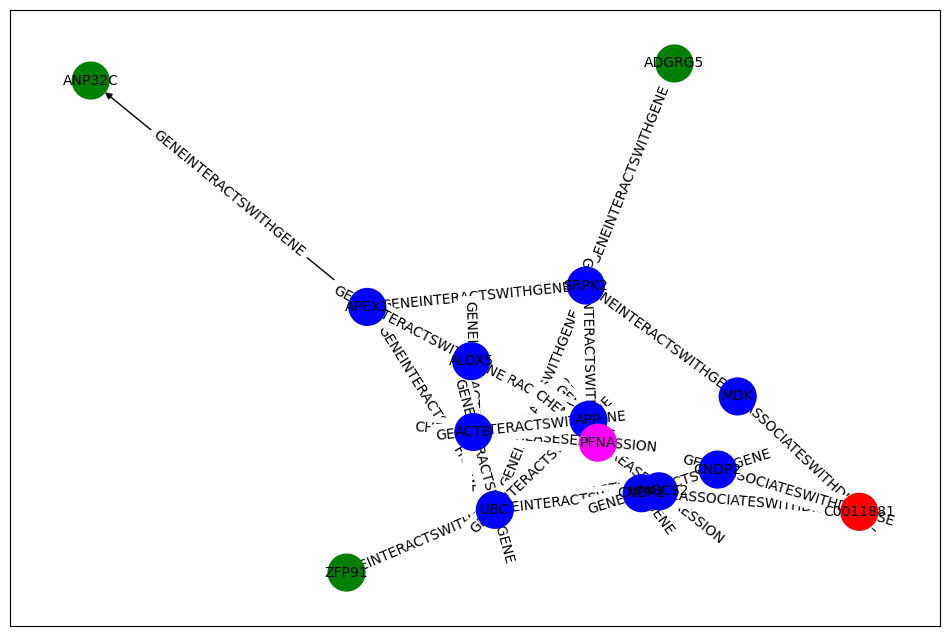

In [93]:
# Color mapping
color_map = {
    'PFAS': 'magenta',
    'Disease': 'red',
    'mediating-protein': 'green',
    'non-identified protein': 'blue'
}

# Compute node colors based on 'type' attribute
node_colors = [color_map[G.nodes[node]['type']] for node in G]

# Draw the graph
plt.figure(figsize=(12, 8))  # Set the figure size
pos = nx.spring_layout(G)  # Layout for the nodes
nx.draw_networkx(G, pos, with_labels=True, node_color=node_colors, node_size=700, edge_color='k', linewidths=1, font_size=10, arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'relationship'))

plt.show()

In [82]:
# Save file

file_path = dir_res / 'ComptoxAI' / 'PFAS_prot_dkd_all_prot_032724.graphml'

# Write the graph to a GraphML file
nx.write_graphml(G, file_path)

print(f"Network saved to {file_path}")

Network saved to /Users/jagoodri/Library/CloudStorage/OneDrive-UniversityofSouthernCalifornia/Goodrich Projects Active/1_proj_dir/0_TODAY/2_results/ComptoxAI/PFAS_prot_dkd_all_prot_032724.graphml
